In [1]:

!pip install kaggle


from google.colab import files
files.upload()

import os
os.makedirs('/root/.kaggle', exist_ok=True)


!cp kaggle.json /root/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json


!kaggle datasets download -d saeedehkamjoo/standard-test-images


!unzip -n standard-test-images.zip -d /content/STI/


!ls

Saving kaggle.json to kaggle (2).json
Dataset URL: https://www.kaggle.com/datasets/saeedehkamjoo/standard-test-images
License(s): unknown
standard-test-images.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  standard-test-images.zip
  inflating: /content/STI/STI/Medical/Brain1.pgm  
  inflating: /content/STI/STI/Medical/Brain2.pgm  
  inflating: /content/STI/STI/Medical/Brain3.pgm  
  inflating: /content/STI/STI/Medical/Brain4.pgm  
  inflating: /content/STI/STI/Medical/Brain5.pgm  
  inflating: /content/STI/STI/Medical/MR.pgm  
  inflating: /content/STI/STI/Medical/bone_scint.pgm  
  inflating: /content/STI/STI/Medical/lungs.pgm  
  inflating: /content/STI/STI/Medical/shoulderCR.pgm  
  inflating: /content/STI/STI/Medical/thyroid_scint.pgm  
  inflating: /content/STI/STI/Medical/ultrasound.pgm  
  inflating: /content/STI/STI/Old classic/ZeldaColor.bmp  
  inflating: /content/STI/STI/Old classic/bridge.pgm  
  inflating: /content/STI/STI/

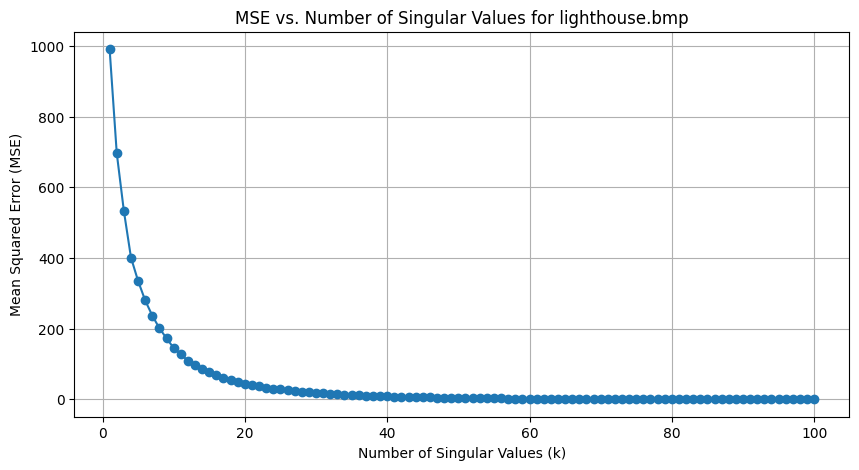

Minimum number of singular values (k) required for lighthouse.bmp with MSE ≤ 0.1: 82


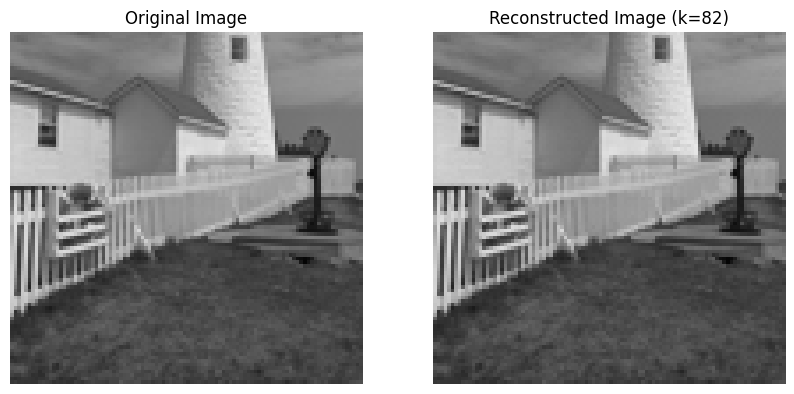

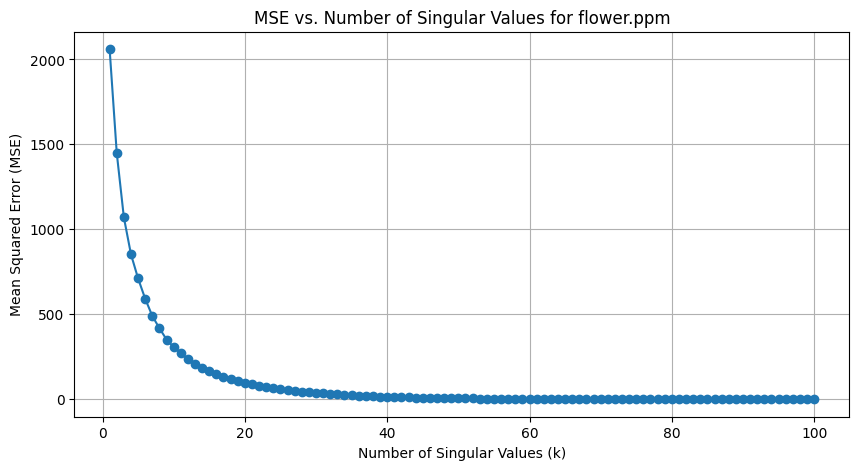

Minimum number of singular values (k) required for flower.ppm with MSE ≤ 0.1: 79


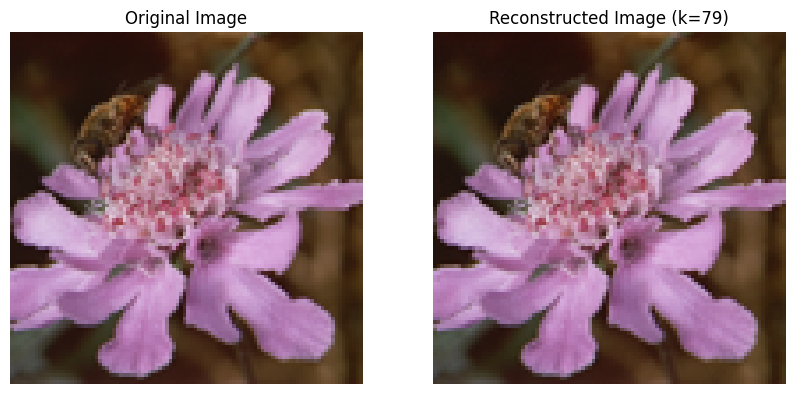

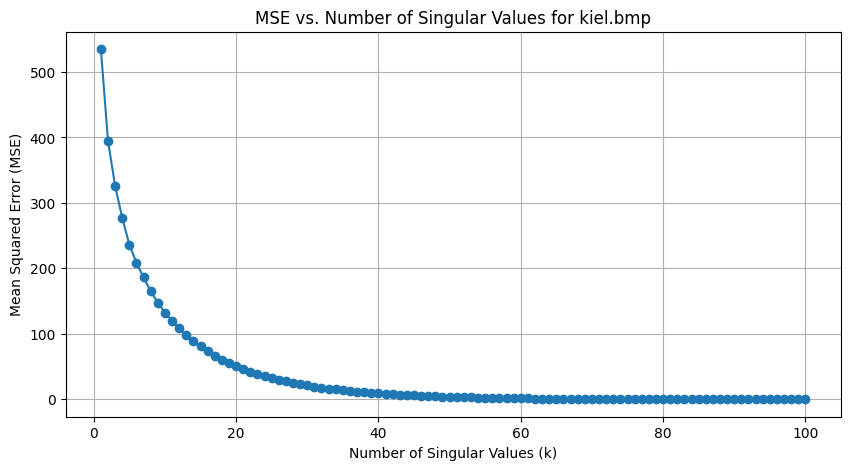

Minimum number of singular values (k) required for kiel.bmp with MSE ≤ 0.1: 79


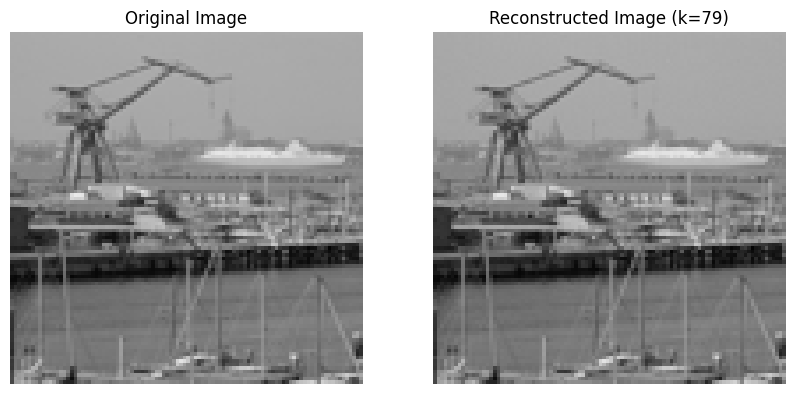

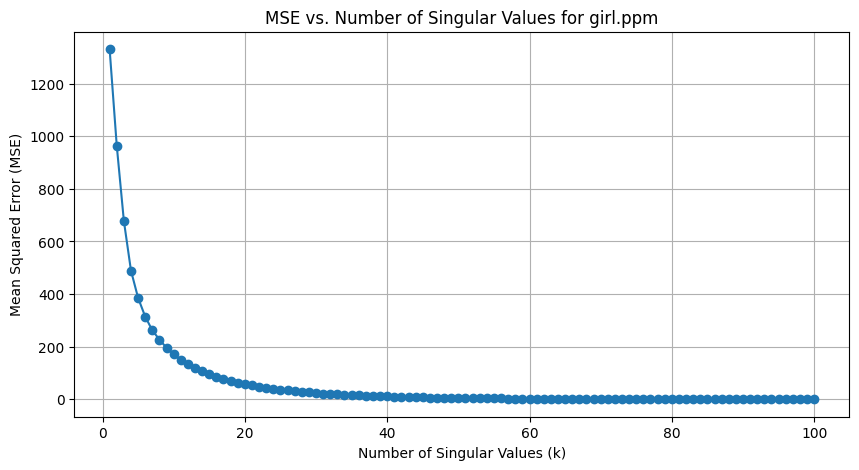

Minimum number of singular values (k) required for girl.ppm with MSE ≤ 0.1: 83


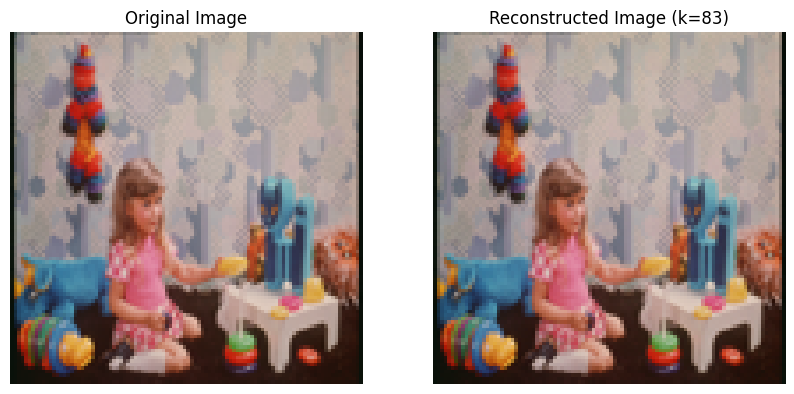

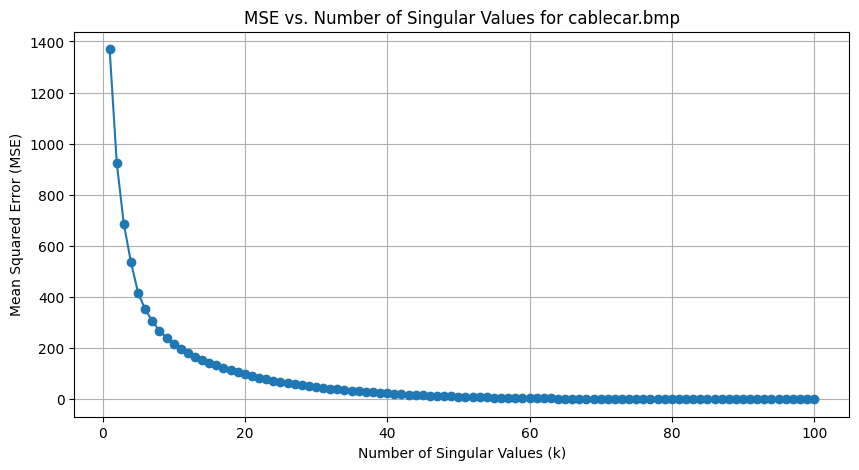

Minimum number of singular values (k) required for cablecar.bmp with MSE ≤ 0.1: 85


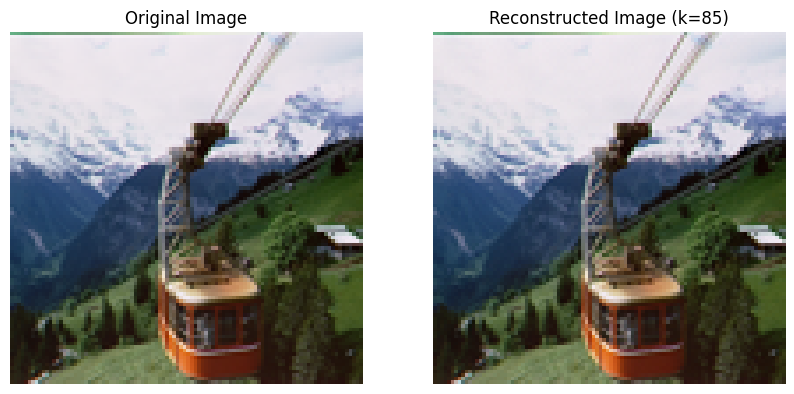

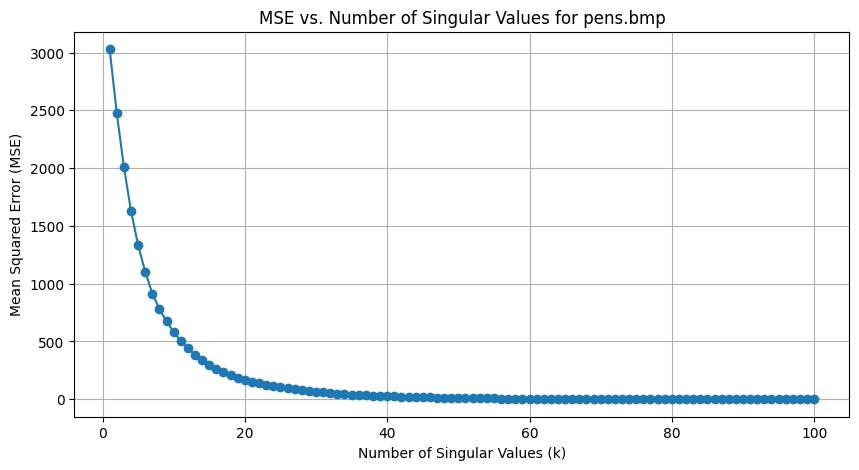

Minimum number of singular values (k) required for pens.bmp with MSE ≤ 0.1: 86


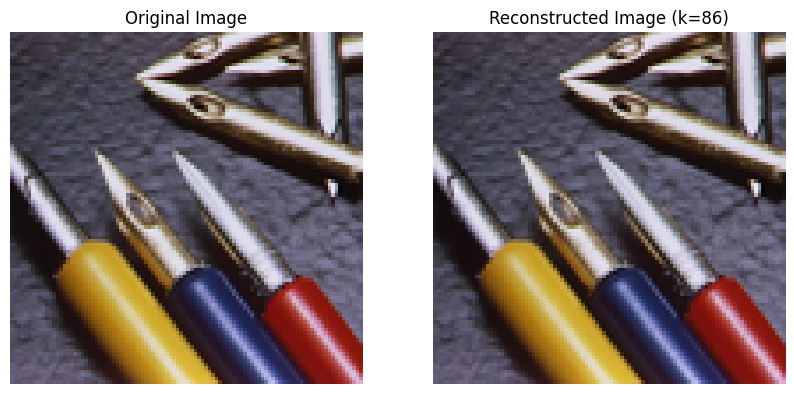

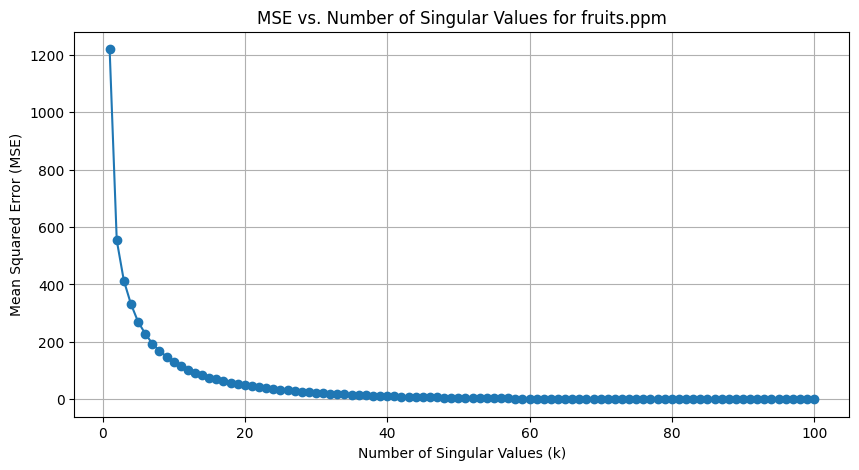

Minimum number of singular values (k) required for fruits.ppm with MSE ≤ 0.1: 84


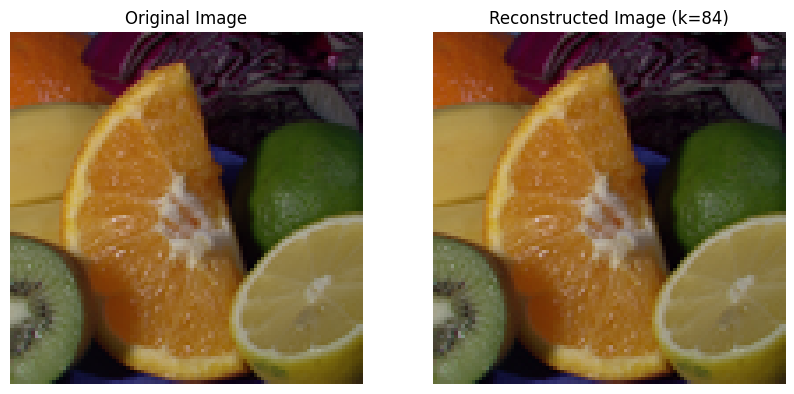

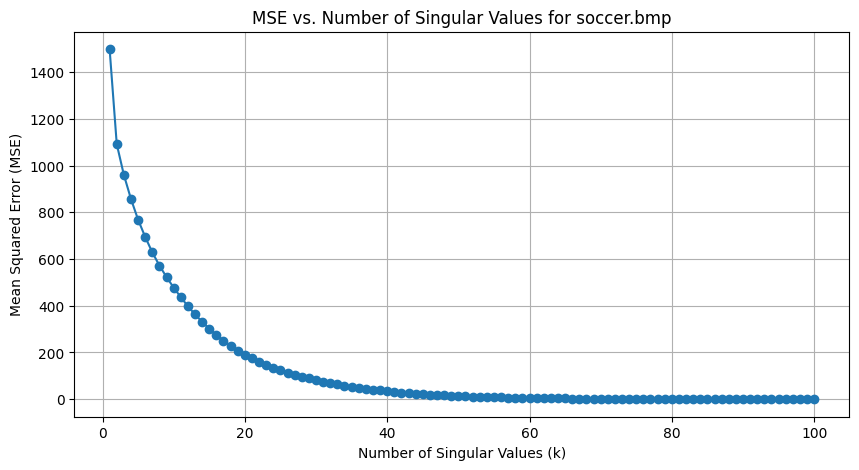

Minimum number of singular values (k) required for soccer.bmp with MSE ≤ 0.1: 88


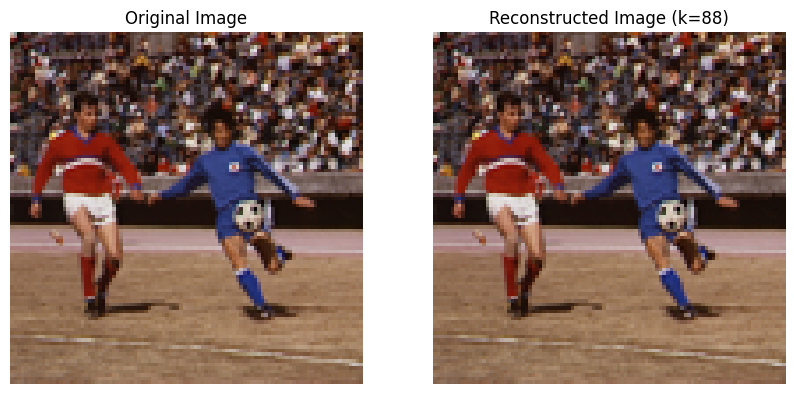

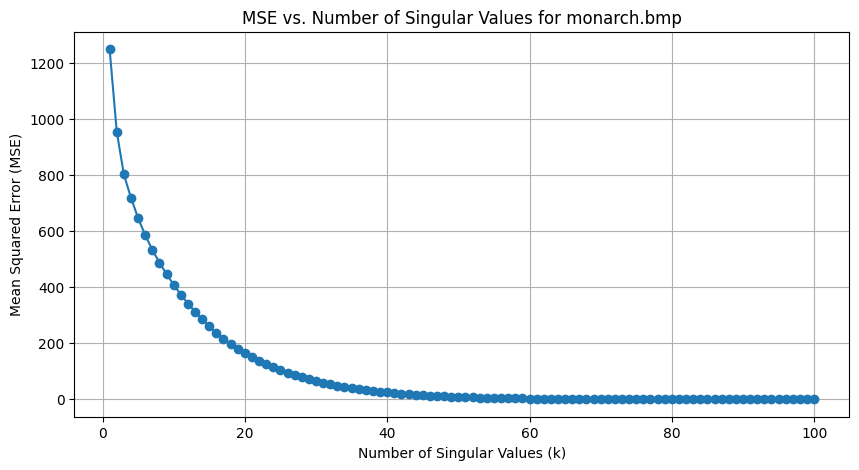

Minimum number of singular values (k) required for monarch.bmp with MSE ≤ 0.1: 78


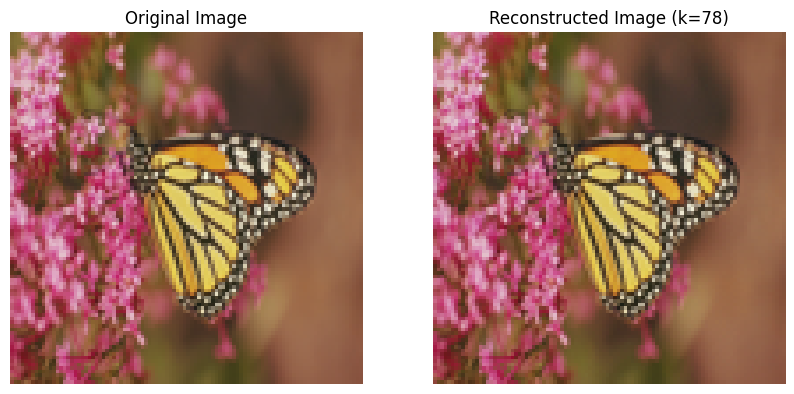

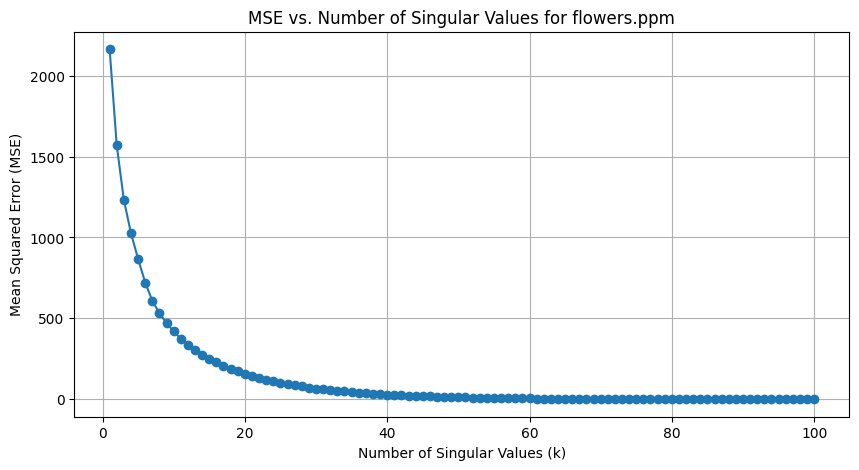

Minimum number of singular values (k) required for flowers.ppm with MSE ≤ 0.1: 86


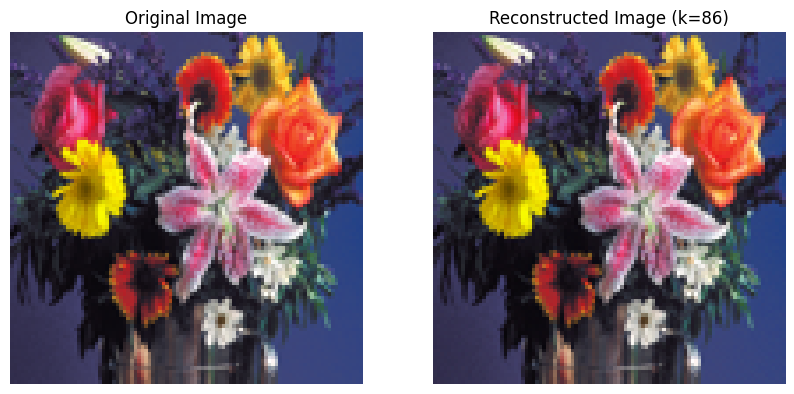

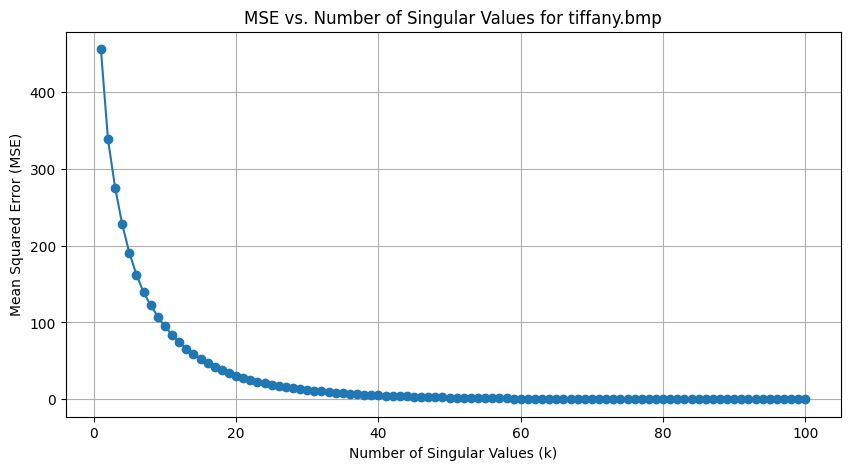

Minimum number of singular values (k) required for tiffany.bmp with MSE ≤ 0.1: 78


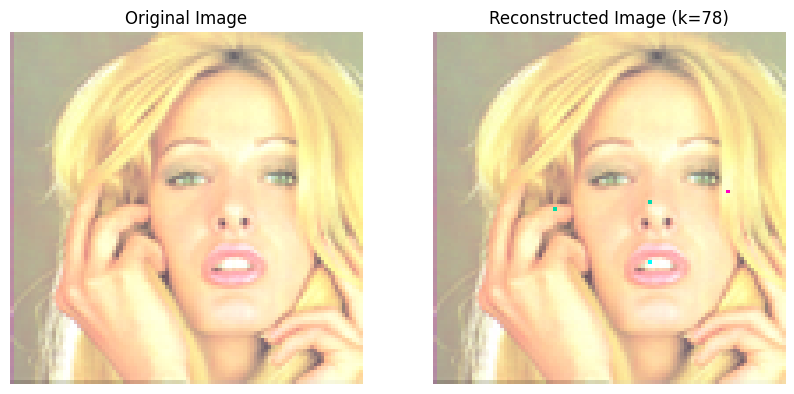

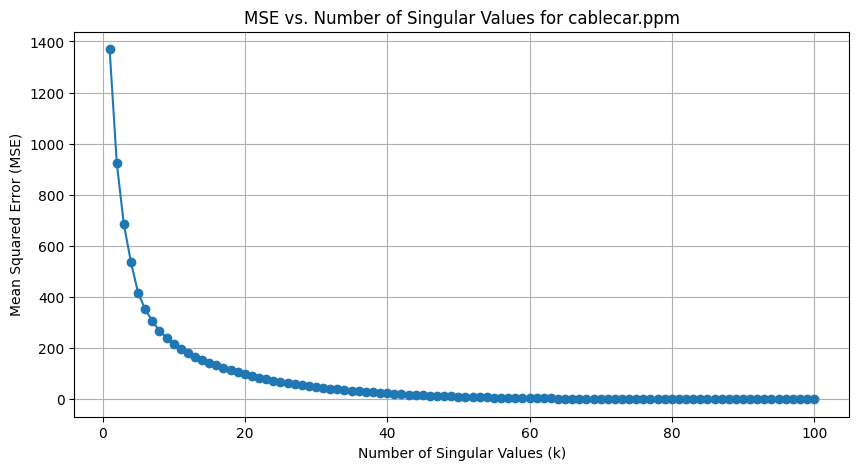

Minimum number of singular values (k) required for cablecar.ppm with MSE ≤ 0.1: 85


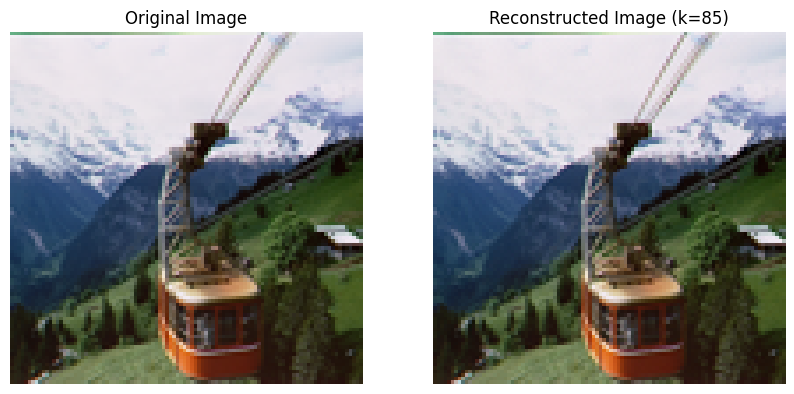

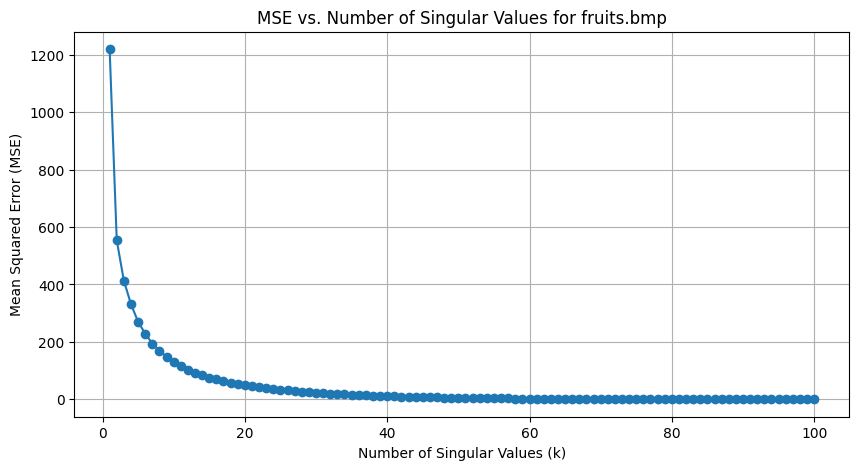

Minimum number of singular values (k) required for fruits.bmp with MSE ≤ 0.1: 84


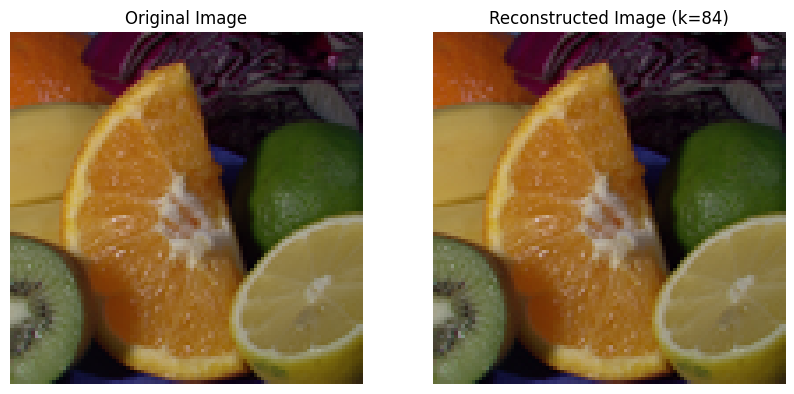

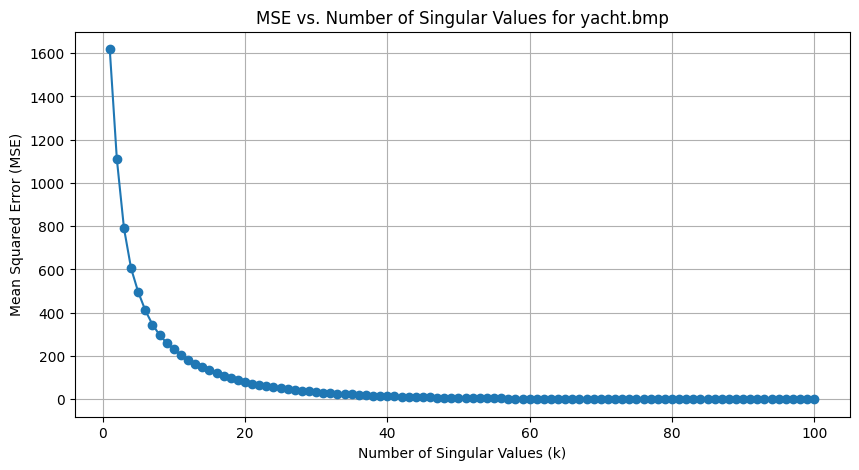

Minimum number of singular values (k) required for yacht.bmp with MSE ≤ 0.1: 84


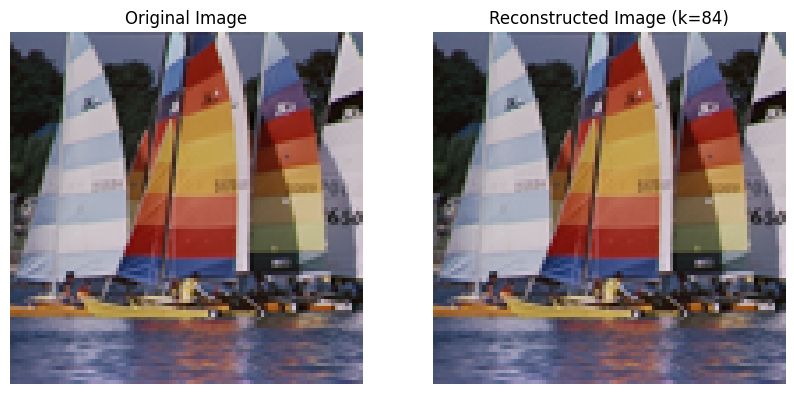

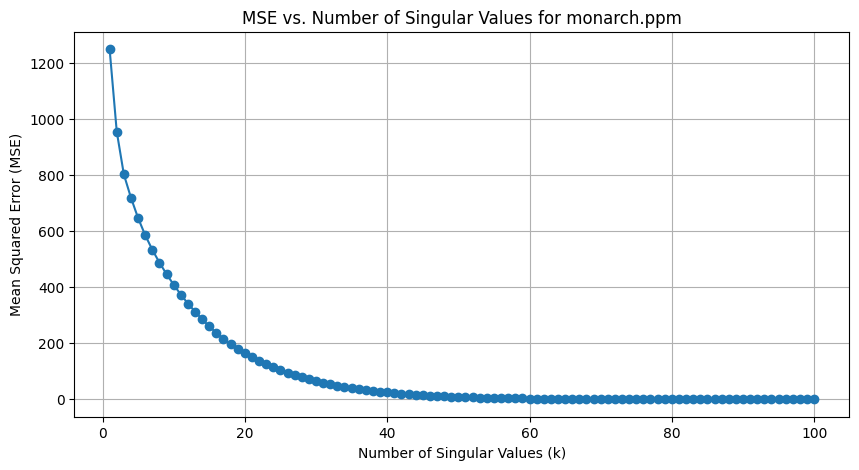

Minimum number of singular values (k) required for monarch.ppm with MSE ≤ 0.1: 78


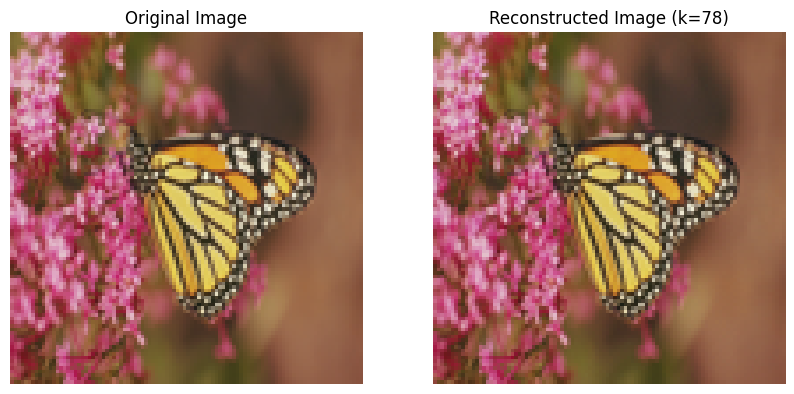

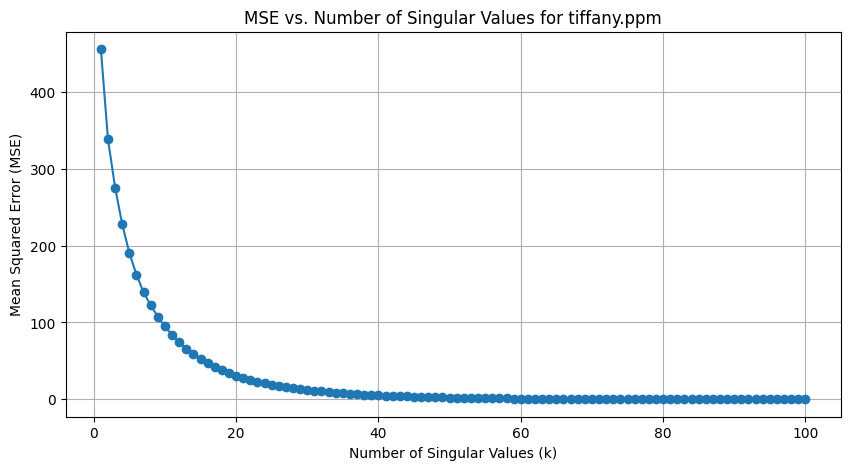

Minimum number of singular values (k) required for tiffany.ppm with MSE ≤ 0.1: 78


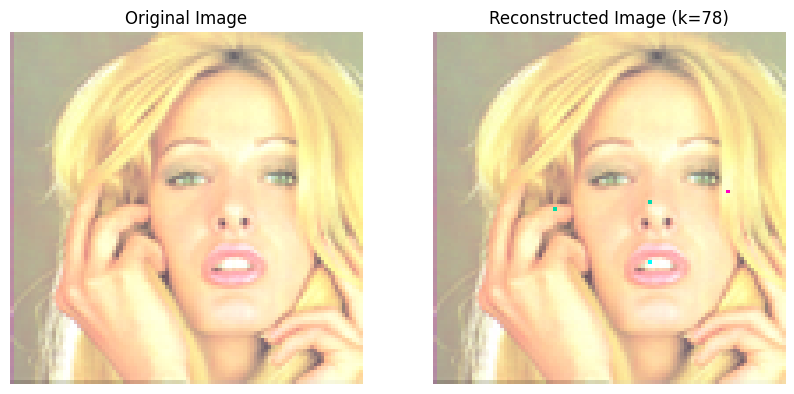

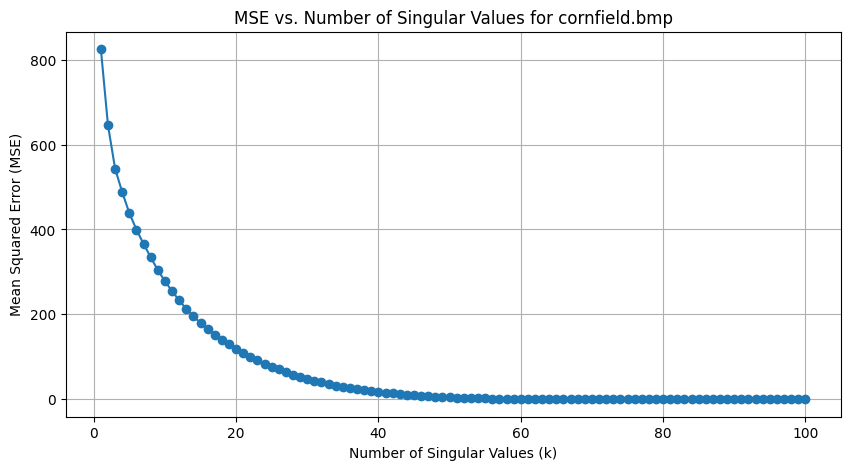

Minimum number of singular values (k) required for cornfield.bmp with MSE ≤ 0.1: 67


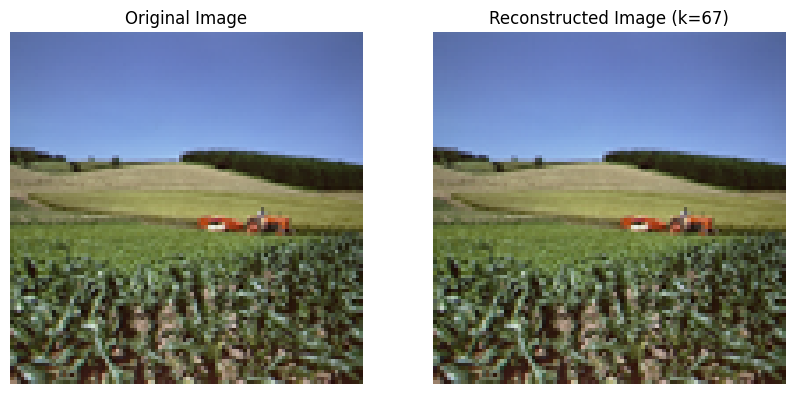

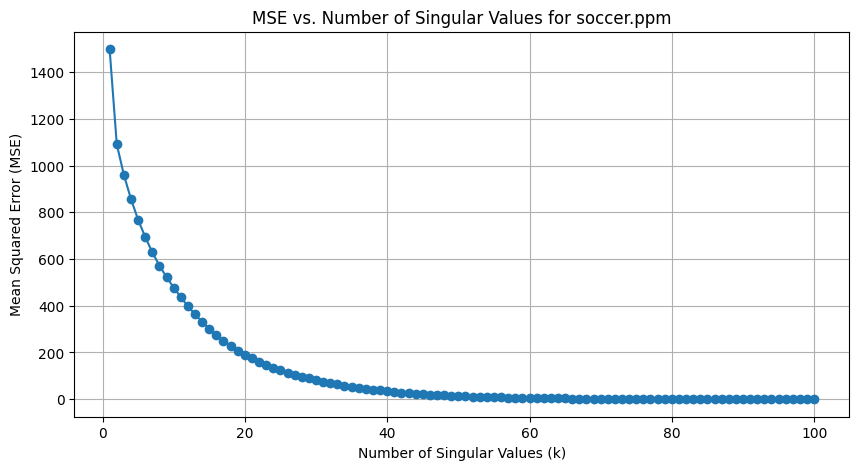

Minimum number of singular values (k) required for soccer.ppm with MSE ≤ 0.1: 88


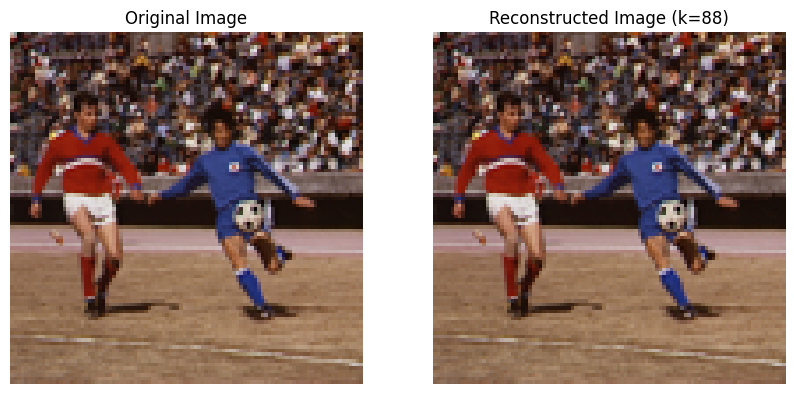

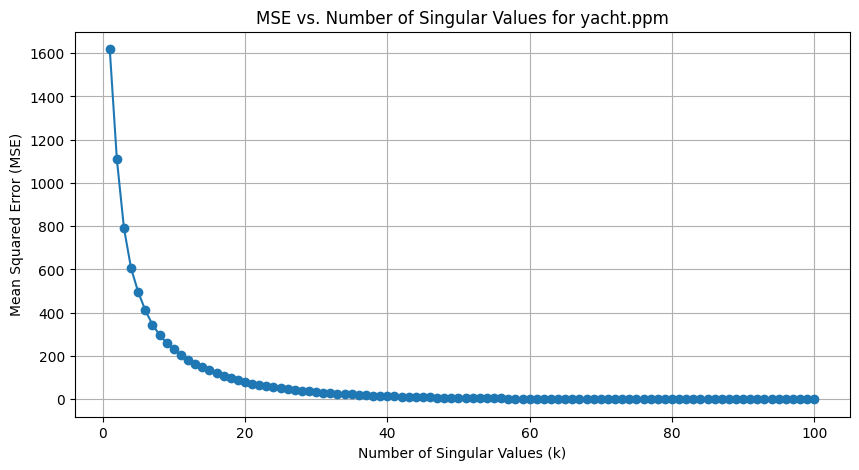

Minimum number of singular values (k) required for yacht.ppm with MSE ≤ 0.1: 84


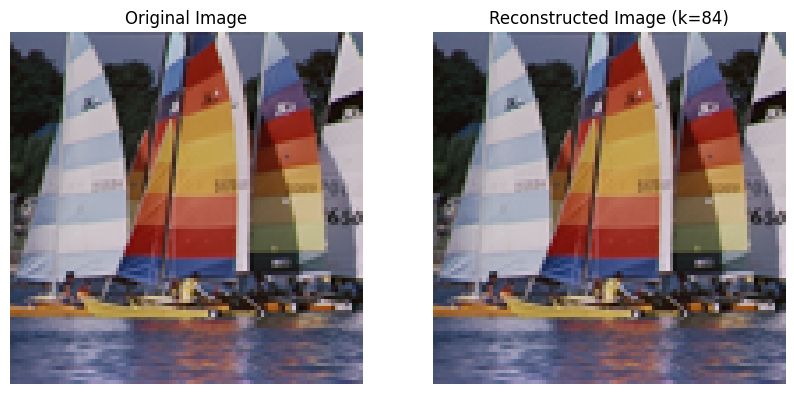

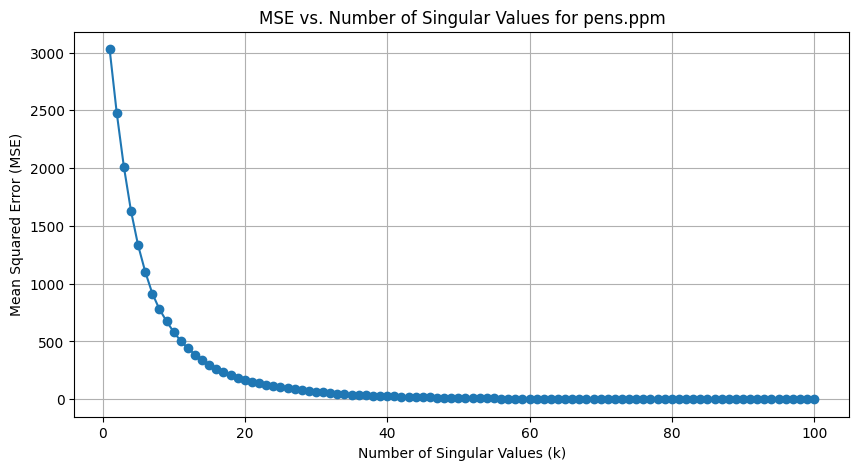

Minimum number of singular values (k) required for pens.ppm with MSE ≤ 0.1: 86


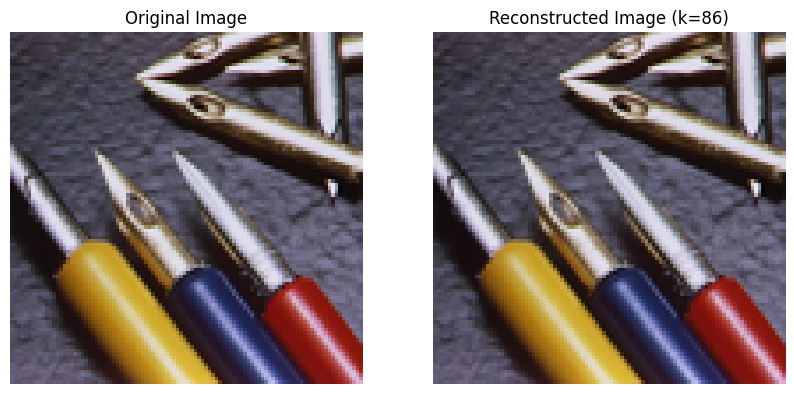

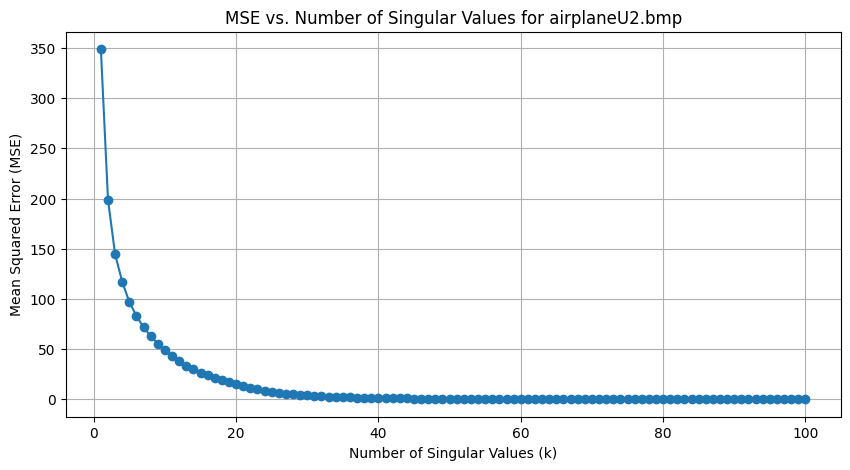

Minimum number of singular values (k) required for airplaneU2.bmp with MSE ≤ 0.1: 65


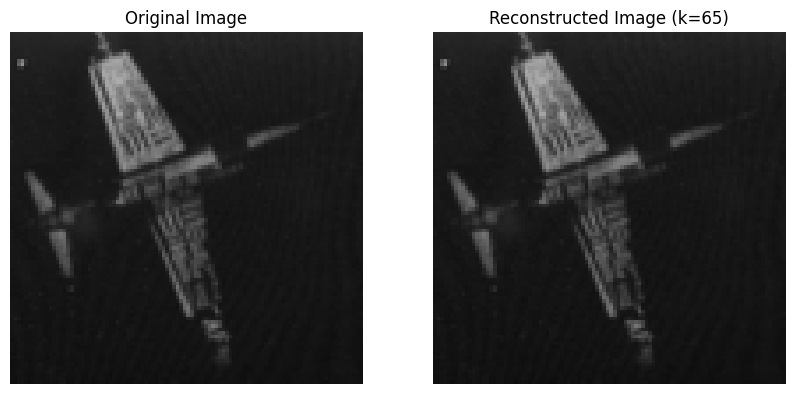

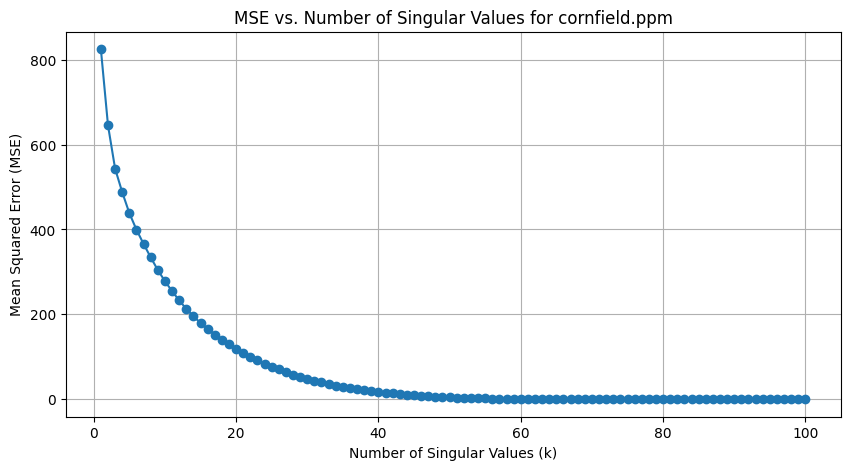

Minimum number of singular values (k) required for cornfield.ppm with MSE ≤ 0.1: 67


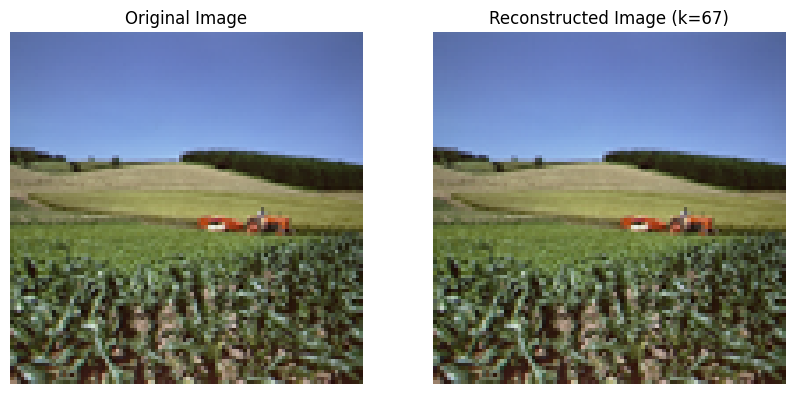

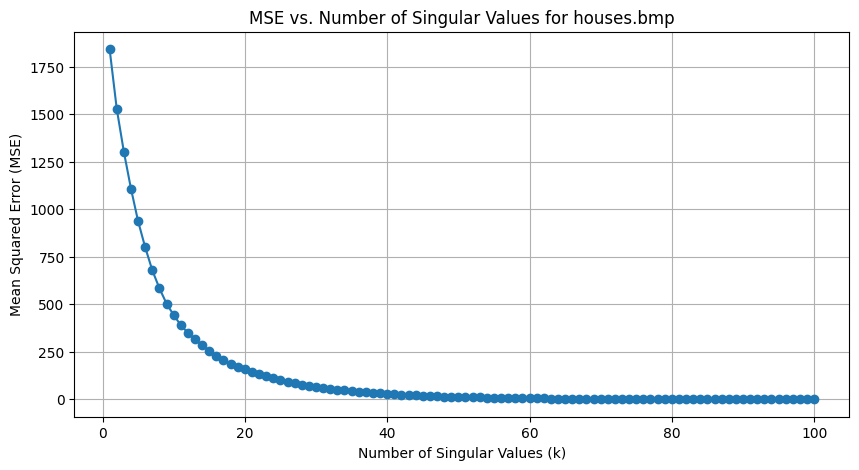

Minimum number of singular values (k) required for houses.bmp with MSE ≤ 0.1: 87


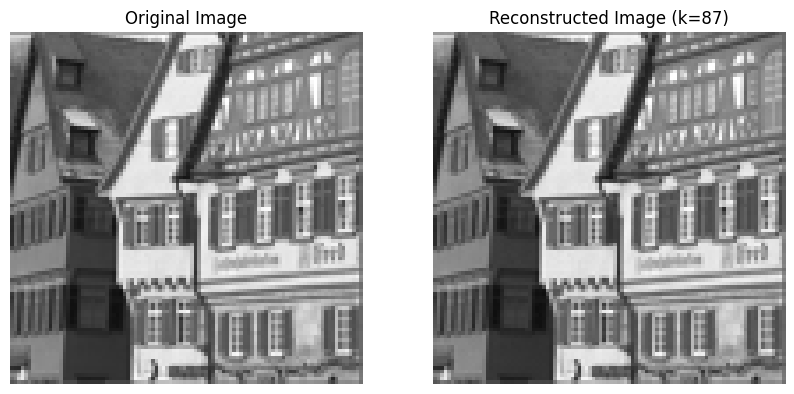

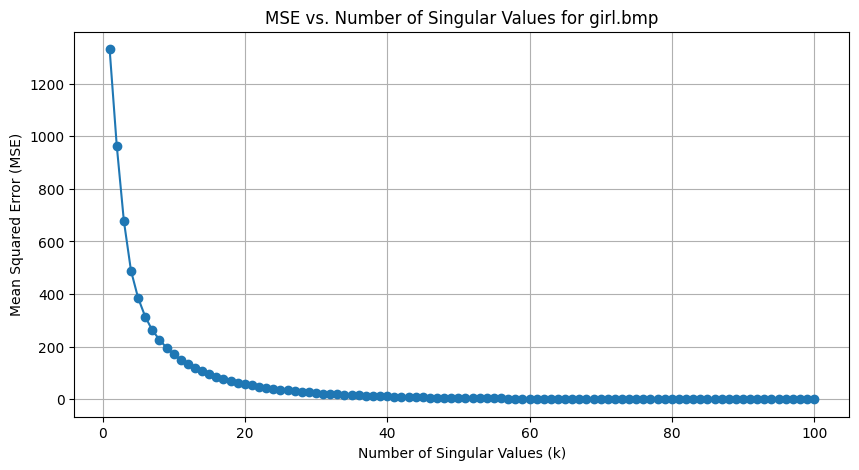

Minimum number of singular values (k) required for girl.bmp with MSE ≤ 0.1: 83


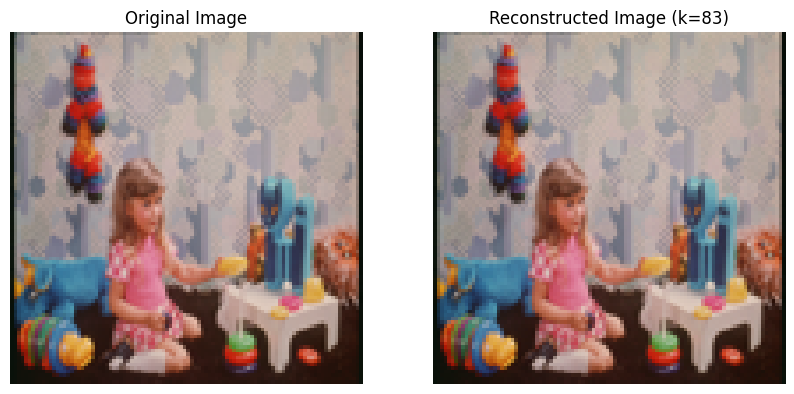

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Function to compress an image using SVD
def compress_image(U, S, VT, k):
    """Reconstructs the image using the first k singular values."""
    return np.dot(U[:, :k], np.dot(np.diag(S[:k]), VT[:k, :]))

# Function to calculate Mean Squared Error (MSE)
def calculate_mse(original, reconstructed):
    """Calculates Mean Squared Error between original and reconstructed image."""
    return np.mean((original - reconstructed) ** 2)

# Load an image and convert to RGB
def load_image(file_path):
    image = Image.open(file_path)
    image = image.resize((100, 100))  # Resize for easier processing
    return np.array(image).astype(float)

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(('.bmp', '.ppm')):  # Load specific formats
            img_path = os.path.join(folder, filename)
            images.append((filename, load_image(img_path)))
    return images

subfolder_path = '/content/STI/Additional'


images = load_images_from_folder(subfolder_path)

for filename, A in images:

    if A.ndim == 2:  # Grayscale image

        A = np.stack((A,)*3, axis=-1)  # Repeat the grayscale channel 3 times

    # Now A should be 3-dimensional (height, width, channels)
    height, width, channels = A.shape

    # Separate the RGB channels
    R = A[:, :, 0]
    G = A[:, :, 1]
    B = A[:, :, 2]

    # Function to perform SVD and reconstruct the image
    def svd_image_compression(image, k):
        U, S, VT = np.linalg.svd(image, full_matrices=False)
        compressed_image = compress_image(U, S, VT, k)
        return compressed_image

    # Trade-off study for each channel
    errors = []
    singular_values = list(range(1, 101))  # Adjust range as needed
    for k in singular_values:
        # Compress each channel separately
        compressed_R = svd_image_compression(R, k)
        compressed_G = svd_image_compression(G, k)
        compressed_B = svd_image_compression(B, k)

        # Reconstruct the compressed RGB image
        compressed_image = np.stack((compressed_R, compressed_G, compressed_B), axis=-1)

        mse = calculate_mse(A, compressed_image)
        errors.append(mse)

    # Plot MSE vs. number of singular values
    plt.figure(figsize=(10, 5))
    plt.plot(singular_values, errors, marker='o')
    plt.title(f'MSE vs. Number of Singular Values for {filename}')
    plt.xlabel('Number of Singular Values (k)')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.grid(True)
    plt.show()

    # Determine minimum k for desired quality
    desired_quality = 0.1  # Desired quality threshold
    min_k = next((k for k, error in zip(singular_values, errors) if error <= desired_quality), None)

    if min_k is not None:
        print(f'Minimum number of singular values (k) required for {filename} with MSE ≤ {desired_quality}: {min_k}')

        # Reconstruct the image using the minimum k found
        compressed_R = svd_image_compression(R, min_k)
        compressed_G = svd_image_compression(G, min_k)
        compressed_B = svd_image_compression(B, min_k)

        # Reconstruct the compressed RGB image
        compressed_image = np.stack((compressed_R, compressed_G, compressed_B), axis=-1)

        # Display original and reconstructed images
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(A.astype(np.uint8))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title(f'Reconstructed Image (k={min_k})')
        plt.imshow(compressed_image.astype(np.uint8))
        plt.axis('off')

        plt.show()
    else:
        print(f'No valid k found for {filename} within the desired quality threshold.')
